# CLASIFICACIÓN DE MENSAJES DE TEXTO CON NAIVE BAYES

## Objetivo

Aplicar técnicas de ciencia de datos sobre mensajes de una lista de correos electrónicos clasificada por categorías, y generar un modelo que pueda predecir la categoría a la que pertenece un mensaje dado.

## Conjunto de datos

El conujunto de datos se extrajo de la lista de correos de debian, de los años 2018 y 2019 de las categorías: `debian-cli debian-jobs debian-r debian-desktop debian-mirrors debian-firewall debian-legal debian-edu debian-python debian-vote`.

El conjunto de datos se puede descargar en: http://misc_publico.rmgss.net/varios/MCD/tests/NaiveBayesText/debian-mailinglist.csv

Los mensajes de la lista de correos se guardaron en el archivo `debian-mailinglist.csv` usando la herramienta https://github.com/strymsg/mailisting-downloader-py

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

In [4]:
data = pd.read_csv('debian-mailinglist.csv', encoding='utf-8')
data.head()

category  year  month  \
0  debian-jobs  2018      6   
1  debian-jobs  2018      9   
2  debian-jobs  2018     12   
3  debian-jobs  2018     10   
4  debian-jobs  2018      3   

                                             message format  
0  Hello All --\n\nCanonical is hiring for the Ub...  plain  
1  Hi!\n\nMy company SUSE is looking for a softwa...  plain  
2  We’re looking for a Linux systems engineer for...  plain  
3  Hello,\n\nFreexian (my company) is doing rathe...  plain  
4  This job offer looks for a german (and english...  plain

In [5]:
data.groupby('category').describe().head(5)

year                                                 \
                  count         mean       std     min     25%     50%   
category                                                                 
debian-cli          7.0  2018.142857  0.377964  2018.0  2018.0  2018.0   
debian-desktop    177.0  2018.632768  0.483418  2018.0  2018.0  2019.0   
debian-edu       2021.0  2018.518555  0.499779  2018.0  2018.0  2019.0   
debian-firewall    20.0  2018.450000  0.510418  2018.0  2018.0  2018.0   
debian-jobs        37.0  2018.324324  0.474579  2018.0  2018.0  2018.0   

                                  month                                        \
                    75%     max   count       mean       std  min   25%   50%   
category                                                                        
debian-cli       2018.0  2019.0     7.0  10.571429  2.992053  4.0  11.0  12.0   
debian-desktop   2019.0  2019.0   177.0   5.796610  3.049476  1.0   4.0   5.0   
debian-edu       2019.0  2019.0  2021.0   6.121227  3.610168  1.0   3.0   6.0   
debian-firewall  2019.0  2019.0    20.0   5.850000  4.380279  1.0   2.0   3.5   
debian-jobs      2019.0  2019.0    37.0   6.324324  3.472544  1.0   3.0   6.0   

                              
                   75%   max  
category                      
debian-cli       12.00  12.0  
debian-desktop    9.00  12.0  
debian-edu       10.00  12.0  
debian-firewall  10.25  12.0  
debian-jobs       9.00  12.0

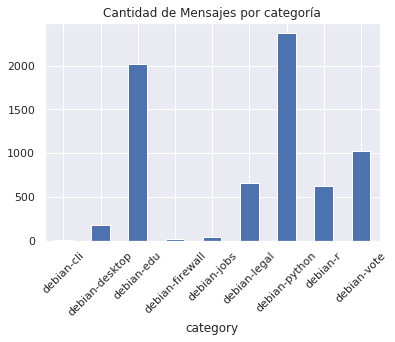

In [6]:
data.groupby('category')['category'].count().plot.bar(title='Cantidad de Mensajes por categoría', rot=45)

Text(0.5, 1.0, 'Mensajes en categorías por año')

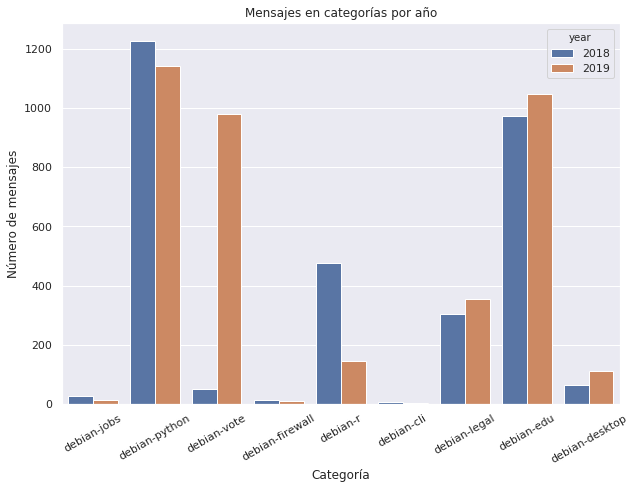

In [7]:
plt.figure(figsize=(10,7))
g = sns.countplot(x='category', hue='year', data=data)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.ylabel('Número de mensajes')
plt.xlabel('Categoría')
g.set_title("Mensajes en categorías por año")

Text(0.5, 1.0, 'Mensajes en categorías por año')

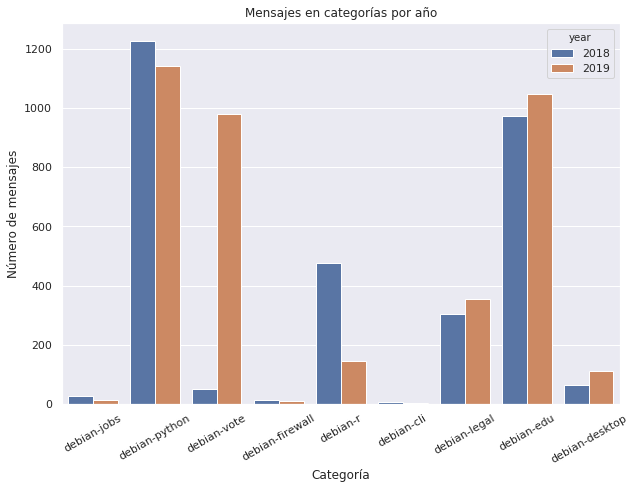

In [8]:
plt.figure(figsize=(10,7))
g = sns.countplot(x='category', hue='year', data=data)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.ylabel('Número de mensajes')
plt.xlabel('Categoría')
g.set_title("Mensajes en categorías por año")

## Análisis exploratorio de datos (EDA)

In [9]:
print(data.shape)
print(data['message'][10][:150])

(6945, 5)
\n<div dir="ltr">A contact that I&#39;ve actually not worked for before is asking for someone to port a VxWorks board support package to Linux.<div><b


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 5 columns):
category    6945 non-null object
year        6945 non-null int64
month       6945 non-null int64
message     6923 non-null object
format      6945 non-null object
dtypes: int64(2), object(3)
memory usage: 271.4+ KB


In [11]:
print('categories:', data['category'].unique())
print('years:', data['year'].unique())
print('months:', data['month'].unique())

categories: ['debian-jobs' 'debian-python' 'debian-vote' 'debian-firewall' 'debian-r'
 'debian-cli' 'debian-legal' 'debian-edu' 'debian-desktop']
years: [2018 2019]
months: [ 6  9 12 10  3  8  5  7  1  2 11  4]


Por ser mensajes de correo electrónico, algunos de estos tienen en el mensaje un bloque con la firma digital, por ejemplo:
```
-----BEGIN PGP SIGNATURE-----

iQFUBAEBCAA+FiEEVZrkbC1rbTJl58uh4+M5I0i1DTkFAl3o8RwgHGlqYWNrc29u
QGNoaWFyay5ncmVlbmVuZC5vcmcudWsACgkQ4+M5I0i1DTlHdAf+JAAuZLrEmzDg
xgFlIKK7nxGabVx1j1LDbP7xnyCv2HOOI9KQfONE/zeuRu4+r2OHNC131LXDl1Om
9pS1N3bQrW5OfQQTHvU+ESM8J+H1UT6EPAZEkNkkDoKTdvlA0NB47pfWjYY5o8tB
T4LkXLcMkccPypOcNjVTN6hbzyL/Krw4CTbkJHSxD3tCRW+nLMLLDLVdAgdE9DMG
gONiU2XE4LonyVhOysWjTDTDYOKpyq0Jo3UmQsf2mrF0cNH3tQDuRpdLZJeb9W1e
hhGdsJmp912oRLyrhGLxqvfOnxWHFp/y4kwKShSAcCfEKeievz+4gLeunYMZDOf8
wHeOyLQSOg==
=l2yV
-----END PGP SIGNATURE-----
```
Este bloque es único por mensaje y no ayuda en el análisis ni para los algoritmos entrenamiento, por lo que se descartan estos bloques de cada mensaje.

In [12]:
messages_cp = []
c = 0
for i in range(len(data['message'])):
    mensaje = data['message'][i]
    try:
        bi = mensaje.index('-----BEGIN PGP SIGNATURE-----')
        be = mensaje.index('-----END PGP SIGNATURE-----')
        nmensaje = mensaje[:bi] + mensaje[be + 28:]
        messages_cp.append(nmensaje)
        c +=1
        #print('procesado mensaje i:', i, len(mensaje), len(nmensaje))
    except Exception as e:
        messages_cp.append(mensaje)
        pass
data['message'] = messages_cp
print('procesados:', c)

procesados: 275


Los mensajes en la lista de correos también están en formato **html** y es necesario limpiar las etiquetas como `<div> <a> ... etc` para solo quedarse con el texto.

In [13]:
import re

def cleanHTMLTags(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# aplica la funcion cleanHTMLTags solo a las filas con formato html
data.loc[data['format'] == 'html', 'message'] = data.loc[data['format'] == 'html']['message'].apply(cleanHTMLTags)

print(data['message'][10][:150],'\n---')
print(data['message'][12][:150])

\nA contact that Ive actually not worked for before is asking for someone to port a VxWorks board support package to Linux.Work in Poway, CA (San Dieg 
---
Hi,

would you like to become my colleague? conova communications Gmbh in
Salzburg/Austria is hiring again.

As speaking at least a few bits of German


Para tener una mejor generalización se convierten todas las palabras a minúsculas por ejemplo "Hello I'm here" a "hello i'm here" aplicando una normalización similar a ([este ejemplo](https://medium.com/analytics-vidhya/randomforest-classifier-vs-multinomial-naive-bayes-for-a-multi-output-natural-language-2426381a5217))

In [14]:
data['message'] = data['message'].astype('U').str.lower()
data['message'][90][:150]

'\\nhi,2018-02-24 19:13 gmt+01:00 stefano rivera stefanor@debian.org:ive finished migrating papt to salsa\\nhttps://salsa.debian.org/python-team/applicat'

También se eliminan las palabras que no aportan a la clasificación, por ejemplo palabras comunes en inglés como `a he due its more one while former has no, etc`. Este conjunto de palabras se define como **stop_words** que luego se incluye en `CountVectorizer` como parámetro para ser ignoradas.

In [15]:
from sklearn.feature_extraction import text
import string
stop_words=text.ENGLISH_STOP_WORDS
# Quitando puntuacion y stop words
def process_text(texto):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    
    #1
    nopunc = [char for char in texto if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    stop_words=text.ENGLISH_STOP_WORDS
    clean_words = [word for word in nopunc.split() if word.lower() not in stop_words]
    
    #3
    return clean_words

data['message'].apply(process_text).head()

0    [hello, canonical, hiring, ubuntu, server, tea...
1    [hi, company, suse, looking, software, enginee...
2    [we’re, looking, linux, systems, engineer, cap...
3    [hello, freexian, company, doing, im, looking,...
4    [job, offer, looks, german, english, speaking,...
Name: message, dtype: object

## Entrenamiento y predicción

Se va a entrenar el conjunto de datos usando la técnica Naive Bayes Multinomial sobre las columnas *message* y *category* para que se produzca un modelo para predecir cuando un mensaje de correo electrónico pertenece a una categoría específica.

In [16]:
df_x=data['message']
print(df_x.head(5))
df_y=data['category']
print(df_y.head(5))

0    hello all --\n\ncanonical is hiring for the ub...
1    hi!\n\nmy company suse is looking for a softwa...
2    we’re looking for a linux systems engineer for...
3    hello,\n\nfreexian (my company) is doing rathe...
4    this job offer looks for a german (and english...
Name: message, dtype: object
0    debian-jobs
1    debian-jobs
2    debian-jobs
3    debian-jobs
4    debian-jobs
Name: category, dtype: object


In [17]:
# 
def constuir_modelo(estimador):
    ''' Funcion para construir un modelo, 
    fuente: https://github.com/cjayidoko/DisasterResponsePipeline/blob/aeffe66906f17376a9d5a2033a502bbcb61e1a19/train_classifier1.py#L113
    '''
    pipeline = Pipeline([
        ('transformer', Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('clf', MultiOutputClassifier(estimador))
    ])

    parameters = {
        'transformer__vect__decode_error': 'ignore',
        'transformer__vect__min_df': 0.004, # ignorar palabras con ocurrencia menor a 0.4%
        'transformer__vect__stop_words': stop_words,
        'transformer__tfidf__use_idf': (True, False)
    }

    model = GridSearchCV(pipeline, param_grid = parameters)

    return model

In [ ]:
def evaluar_modelo(modelo, X_text, Y_test, category_names):
    ''' 
        returns a dataframe of the important score metrics of the results of the multi-classification problem
    including the accuracy, precision, recall, and f1-score.
    
    Args:
        model - The model to be evaluated
        X_test - the true values of the independent varaible
        Y_test - The true values of the dependent variable
        y_pred - the predictions of dependent varable using the model
        labels - the list of the names of the columns of the Y_test
    Returns:
        A dataframe of the important score metrics of the results of the multi-classification problem
        including the accuracy, precision, recall, and f1-score
    Fuente: https://github.com/cjayidoko/DisasterResponsePipeline/blob/aeffe66906f17376a9d5a2033a502bbcb61e1a19/train_classifier1.py#L113
    '''
    